# Capstone Project: Predicting New York Times Cooking Recipe Popularity
### Notebook 03 - Modeling


_Author: Joe Serigano (jserigano4@gmail.com)_

---

**Objectives:**
- Create classification models to predict whether a recipe will create higher than average site traffic based on several features.
- Examine the importance of different features on rating count (site traffic) to determine what makes a recipe more popular than others.

The main question we are trying to answer is: **What characteristics of a recipe are most likely to increase the popularity (and overall site traffic), and what changes can be made to increase recipe popularity before posting?**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from mlxtend.classifier import StackingCVClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action="ignore")

In [2]:
recipes = pd.read_csv('data/recipes_final_df.csv')
recipes.head()

,Unnamed: 0,recipe_url,scraped,title,date,description,total_time,yields,n_steps,steps,...,author_Yotam Ottolenghi,author_Zainab Shah,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,high_traffic
0,0,https://cooking.nytimes.com/recipes/1023386-su...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Summer Fruit Compote,2022-08-13,"In another era, this kind of chopped fruit sal...",5.0,6,2.0,"In a large bowl, combine melon, apricots, nect...",...,0,0,0,0,1,0,0,0,0,0
1,1,https://cooking.nytimes.com/recipes/1023385-sl...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Slow-Cooked Lamb Shoulder With Green Beans,2022-08-13,There are many ways to achieve a succulent bra...,240.0,6,6.0,Prepare a covered gas or charcoal grill for me...,...,0,0,0,0,1,0,0,0,0,0
2,2,https://cooking.nytimes.com/recipes/1023384-to...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Tomato Salad With Smoky Eggplant Flatbread,2022-08-13,Buy lavash or pita at a local Middle Eastern m...,40.0,6,6.0,"Set the whole, unpeeled eggplant directly over...",...,0,0,0,0,1,0,0,0,0,0
3,3,https://cooking.nytimes.com/recipes/1019764-po...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Pork Meatballs With Ginger and Fish Sauce,2018-11-16,These nuoc cham-inspired meatballs are perfect...,20.0,4,3.0,"Heat oven to 425 degrees. In a large bowl, com...",...,0,0,1,0,0,0,0,0,0,1
4,4,https://cooking.nytimes.com/recipes/1023380-ba...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Basil and Tomato Fried Rice,2022-08-01,Summer’s dynamic duo of tomato and basil make ...,15.0,4,5.0,"In a bowl, whisk the eggs with 1/2 teaspoon sa...",...,0,0,0,1,0,0,0,0,0,0


## Baseline model:

Our baseline model accuracy is the probability that a given recipe will have a total recipe review count lower than the average review count. Our baseline accuracy is 50.01% in this case.

In [3]:
recipes['high_traffic'].value_counts(normalize = True)

0    0.500137
1    0.499863
Name: high_traffic, dtype: float64

## Modelling:

---

Next, we will split our data into our features (X) and our target (y) variable, 'high_traffic', and perform a train/test split. The value of 'high_traffic' is 1 if the recipe has a rating count higher than the average count and 0 if the recipe does not. We will be building multiple classification models and determine which are most accurate. Since we care mostly about the amount of true positives and true negatives for this model we will be using accuracy as a metric for success in our modeling.

In [4]:
y = recipes['high_traffic']
X = recipes.drop(columns = ['high_traffic','log_rating_count','rating_count','Unnamed: 0', 'recipe_url', 'scraped', 'title', 'date', 'description','steps',
                            'ingredients','tags','cuisine','category','category_list'])

In [5]:
# Splitting our full training data into training and testing sets for model evaluation within this notebook.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [6]:
# Standardizing features
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

The function below makes it easier to run a grid search on many different models.

In [7]:
def model_run(mod_inst, model, mod_params):
    '''
    Function to run model given estimator and parameters for GridSearchCV. 
    This function will:
    - Fit training data with model
    - Generate model predictions
    - Evaluate model performance with various metrics
    - Print classification report and plot confusion matrix
    - Plot ROC AUC curve
    - Output metric results to DataFrame
    **************
    Input params:
    mod_inst: String of model abbreviation
    model: Estimator to use with GridsearchCV model  
    mod_params: Parameters to use for estimator
    **************
    '''
    pipe = Pipeline([
        (mod_inst, model)])
    
    gs = GridSearchCV(pipe, param_grid = {**mod_params})
    gs.fit(X_train_sc, y_train)
    
    print('*'*80)
    print(f'MODEL = {model}')
    print('*'*80)
    print(f'Best fitting parameters: {gs.best_params_}\n')
    print(f'Best score: {round(gs.best_score_, 3)}')
    print(f'Test score: {round(gs.score(X_test_sc, y_test), 3)}\n')
    
    # Get predictions
    preds = gs.predict(X_test_sc)
    pred_prob_test = gs.predict_proba(X_test_sc)[:,1]
    pred_prob_train = gs.predict_proba(X_train_sc)[:,1]
    
    print('Classification report:')
    print(classification_report(y_test, preds))
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    plot_confusion_matrix(gs, X_test_sc, y_test, cmap='Blues', values_format='d')
    title = str(model) + ' Confusion Matrix'
    plt.title(title)
    plt.tight_layout();
    fig_name = 'figures/' + 'confusion_matrix_'+ mod_inst + '.png'
    plt.savefig(fig_name,facecolor = 'white');
    
    plot_roc_curve(gs, X_test_sc, y_test, label = str(model))
    title = str(model) + ' ROC-AUC Curve'
    plt.title(title)
    plt.plot([0,1], [0,1],
             label = 'baseline',
             linestyle = '--')
    plt.legend()
    plt.tight_layout();
    fig_name = 'figures/' + 'roc_curve_'+ mod_inst + '.png'
    plt.savefig(fig_name,facecolor = 'white')
    
    # Save best model results to Dataframe
    df = pd.DataFrame()
    df['model'] = [f'{mod_inst}']
    df['best_params'] = [gs.best_params_]
    df['train_score'] = gs.best_score_
    df['test_score'] = gs.score(X_test_sc, y_test)
    df['train_roc_auc'] = roc_auc_score(y_train, pred_prob_train)
    df['test_roc_auc'] = roc_auc_score(y_test, pred_prob_test)
    df['sensitivity'] =  tp / (tp + fn)
    df['specificity'] = tn / (tn + fp)
    df['precision'] = tp / (tp + fp)
    df['f1_score'] = f1_score(y_test, preds)
    df['accuracy'] = accuracy_score(y_test, preds)
    df['tn'] = tn
    df['fp'] = fp
    df['fn'] = fn
    df['tp'] = tp
    
    return df

In [8]:
# Define list of DataFrames to save all best model outputs
df_all = []

## 1. LogisticRegression()

In [ ]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],
    
    'lr__l1_ratio':[0, 0.5, 1],

     # Trying different alphas of: 10, 1, 0.1  (C = 1/alpha)
    'lr__C':[0.1, 1, 10],
}

lr_mod = model_run('lr', LogisticRegression(), lr_params)
lr_mod.head().T

df_all.append(lr_mod)

## 2. KNeighborsClassifier()

In [ ]:
knn_params = {'knn__n_neighbors': [3, 5, 7],
              'knn__weights': ['uniform', 'distance']}

knn_mod = model_run('knn', KNeighborsClassifier(), knn_params)
knn_mod.head().T

df_all.append(knn_mod)

# 3. RandomForestClassifier()

In [ ]:
rf_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 5, 25, 40],
    'rf__min_samples_leaf': [1, 3, 5]
}

rf_mod = model_run('rf', RandomForestClassifier(), rf_params)
rf_mod.head().T

df_all.append(rf_mod)

## 4. AdaBoostClassifier()

In [ ]:
ada_params = {'ada__n_estimators': [50, 100, 250, 500],
              'ada__learning_rate': [0.1, 0.25, 0.5, 0.75, 0.9],
             }

ada_mod = model_run('ada', AdaBoostClassifier(), ada_params)
ada_mod.head().T

df_all.append(ada_mod)

# 5. GradientBoostingClassifier()

In [ ]:
gb_params = {'gb__max_depth': [3, 4],
             'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.1, 0.2, 0.3],
}

gb_mod = model_run('gb',GradientBoostingClassifier(), gb_params)
gb_mod.head().T

df_all.append(gb_mod)

## 6. XGBoost

In [ ]:
xgb_params = { 
              'xgb__learning_rate' : [0.1, 0.3],
              'xgb__max_depth' : [6, 7], 
              'xgb__n_estimators' : [100, 150],
              'xgb__reg_alpha' : [1, 2],
              'xgb__reg_lambda' : [1, 2],
              'xgb__gamma' : [1, 3],
             }

xgb_mod = model_run('xgb',XGBClassifier(), xgb_params)
xgb_mod.head().T

df_all.append(xgb_mod)

In [ ]:
full_df = pd.concat(df_all)
pd.set_option('display.max_colwidth', None)
full_df.sort_values(by=['accuracy'], ascending=False).reset_index(drop=True)

## Model stacking:

---

Next, we'll try to obtain a better performing model by stacking our best models using StackingCVClassifier. We'll create the stacked model by including the best hyperparameters from each model above, with GradientBoostClassifier() as the final estimator since performed the best.

In [ ]:
clf0 = KNeighborsClassifier()
clf1 = LogisticRegression(C = 10, penalty = 'l2')
clf2 = AdaBoostClassifier(learning_rate = 0.25, n_estimators = 500)
clf3 = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, n_estimators =200)
clf4 = XGBClassifier(gamma = 3, learning_rate = 0.1, max_depth = 7, n_estimators = 100, reg_alpha = 2, reg_lambda = 2)
metaclf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 500)



stack = StackingCVClassifier(classifiers=[clf0,clf1, clf2, clf3, clf4],
                            meta_classifier=metaclf,
                            cv = 6,
                            use_features_in_secondary=True,
                            store_train_meta_features=False,
                            random_state=42)

stack.fit(X_train_sc, y_train)

pred = stack.predict(X_test_sc)
f1 = f1_score(y_test, pred)
acc = accuracy_score(y_test, pred)
print(f'f1 score: {f1}')
print(f'accuracy score: {acc}')

Unfortunately our stacked model did not do better than GradientBoostClassifier() alone! Let's try again without the hyperparameters.

In [ ]:
clf0 = KNeighborsClassifier()
clf1 = LogisticRegression()
clf2 = AdaBoostClassifier()
clf3 = RandomForestClassifier()
clf4 = XGBClassifier()
metaclf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 500)


stack = StackingCVClassifier(classifiers=[clf0,clf1, clf2, clf3, clf4],
                            meta_classifier=metaclf,
                            cv = 6,
                            use_features_in_secondary=True,
                            store_train_meta_features=False,
                            random_state=42)

stack.fit(X_train_sc, y_train)

pred = stack.predict(X_test_sc)
f1 = f1_score(y_test, pred)
acc = accuracy_score(y_test, pred)
print(f'f1 score: {f1}')
print(f'accuracy score: {acc}')

## Feature importance

---

Our best fitting model is still GradientBoostClassifier() with an accuracy of 0.788. Let's move forward with this model and determine the most important features for recipe popularity and site traffic.

In [10]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 500)

gbc.fit(X_train_sc, y_train)

GradientBoostingClassifier(n_estimators=500)

First we'll look at the most important features overall, then we'll divide the features into categories.

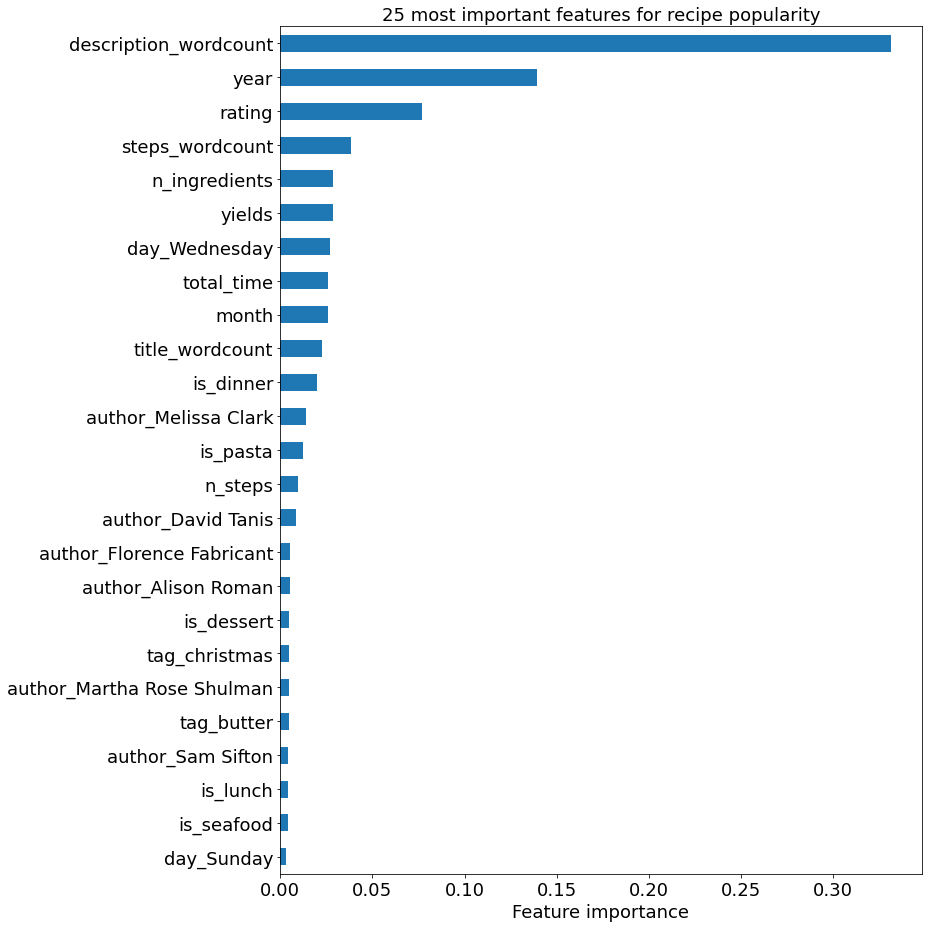

In [21]:
fsize = 18
plt.figure(figsize=(13,13))
gb_feature_imp = pd.Series(gbc.feature_importances_, index=X.columns).sort_values(ascending=False).head(25)
gb_feature_imp.sort_values().plot(kind = 'barh', fontsize = fsize)
plt.title('25 most important features for recipe popularity', fontsize = fsize)
plt.xlabel('Feature importance', fontsize = fsize)
plt.tight_layout();
plt.savefig('figures/most_imp_features.png',facecolor = 'white')

Next, let's look at individual categories: authors and tags.

In [16]:
author_true = X.columns.str.contains('author')
author_index = [i for i, x in enumerate(author_true) if x];

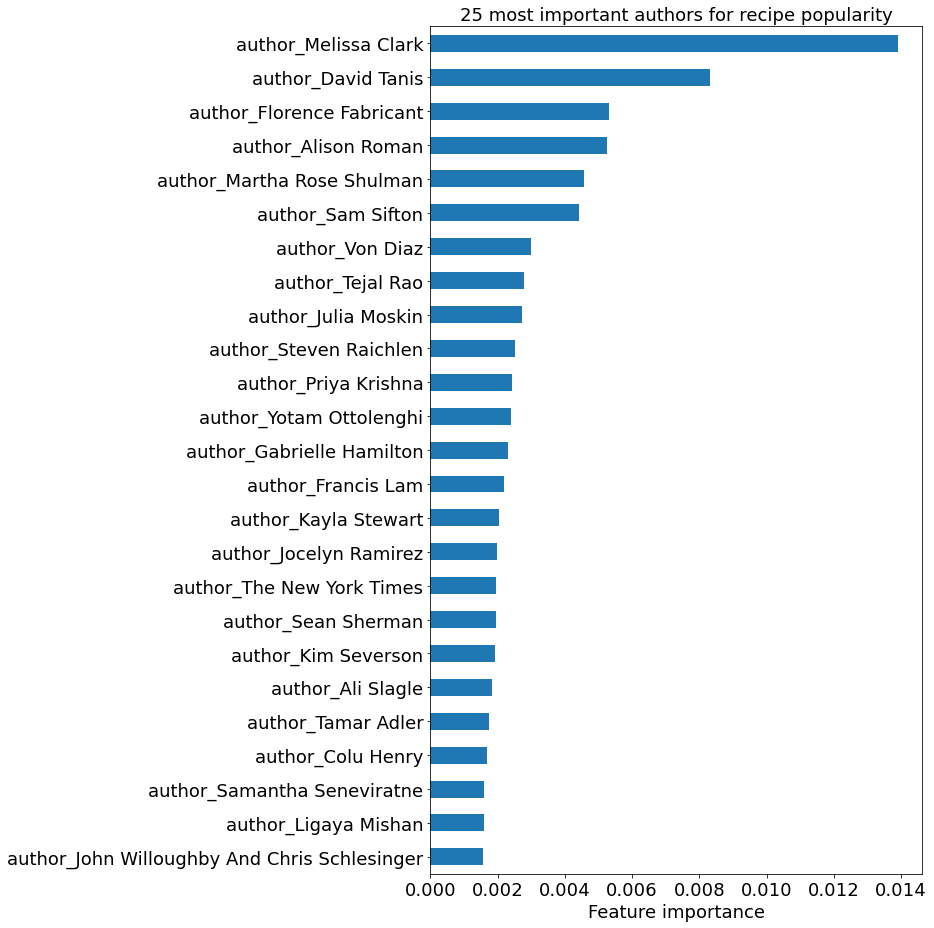

In [23]:
plt.figure(figsize=(13,13))
gb_feature_imp = pd.Series(gbc.feature_importances_[author_index], index=X.columns[author_index]).sort_values(ascending=False).head(25)
gb_feature_imp.sort_values().plot(kind = 'barh', fontsize = fsize)
plt.title('25 most important authors for recipe popularity', fontsize = fsize)
plt.xlabel('Feature importance', fontsize = fsize)
plt.tight_layout();
plt.savefig('figures/most_imp_authors.png',facecolor = 'white')

In [18]:
tag_true = X.columns.str.contains('tag_')
tag_index = [i for i, x in enumerate(tag_true) if x];

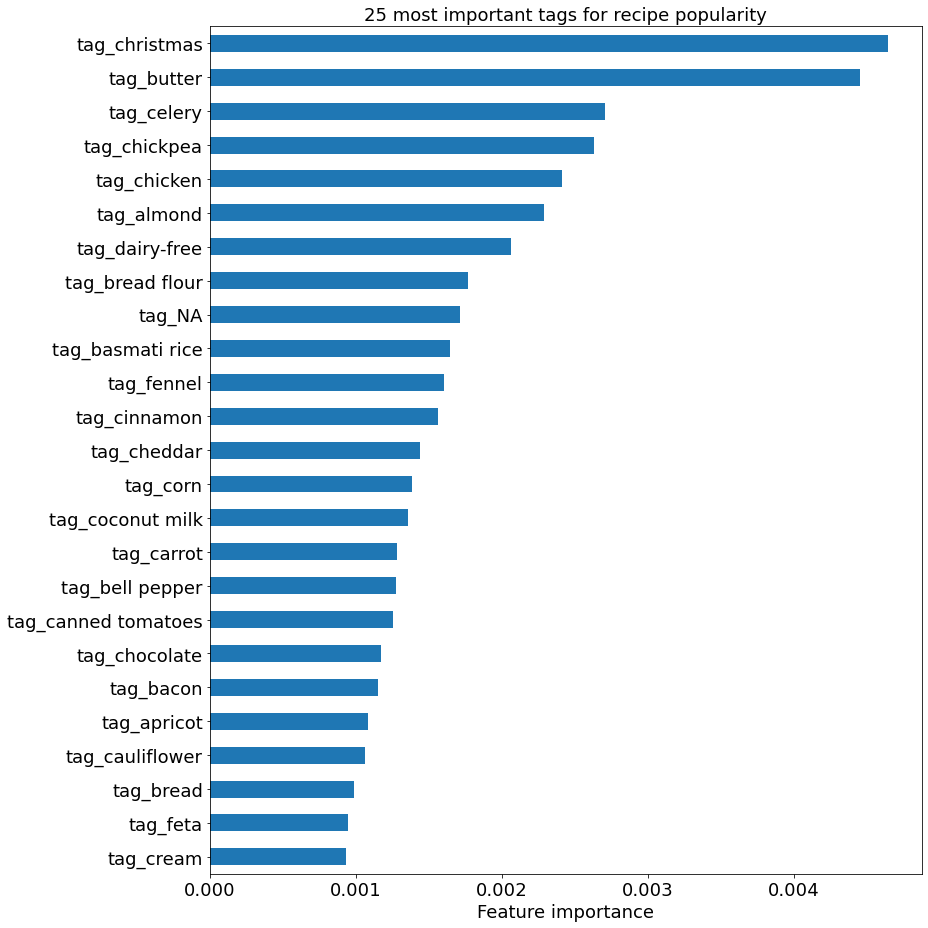

In [24]:
plt.figure(figsize=(13,13))
gb_feature_imp = pd.Series(gbc.feature_importances_[tag_index], index=X.columns[tag_index]).sort_values(ascending=False).head(25)
gb_feature_imp.sort_values().plot(kind = 'barh', fontsize = fsize)
plt.title('25 most important tags for recipe popularity', fontsize = fsize)
plt.xlabel('Feature importance', fontsize = fsize)
plt.tight_layout();
plt.savefig('figures/most_imp_tags.png',facecolor = 'white')